# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.

In [1]:
# 1 Modeling Volatility and VaR
# Imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Data
FILEPATH = '../data/spy_data.xlsx'
data = pd.read_excel(FILEPATH, sheet_name='total returns')
data['date'] = pd.to_datetime(data['date'])
data['Excess Returns'] = data['SPY'] - data['^IRX']
data.set_index('date', inplace = True)
data.head()

,SPY,^IRX,Excess Returns
date,,,
1994-01-04,0.004035,0.000122,0.003913
1994-01-05,0.002009,0.000122,0.001888
1994-01-06,0.000000,0.000121,-0.000121
1994-01-07,0.006016,0.000119,0.005897
1994-01-10,0.011960,0.000119,0.011841


,Historic VaR
date,
2001-01-02,-0.017699
2001-01-03,-0.017794
2001-01-04,-0.017792
2001-01-05,-0.017789
2001-01-08,-0.017858


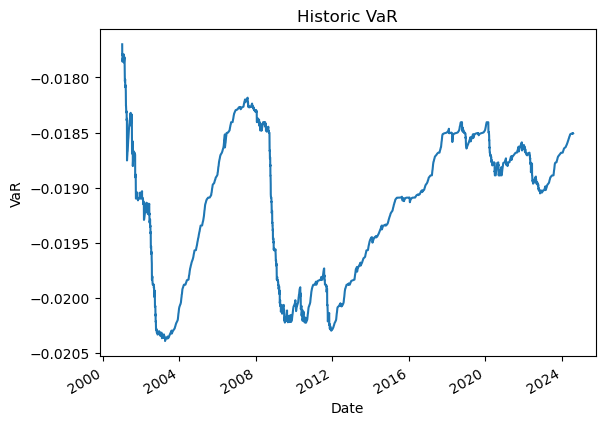

In [3]:
# 1.1 Historic VaR
VaR = pd.DataFrame()
VaR['Historic VaR'] = (data['Excess Returns'].shift().expanding().quantile(.05))
VaR.loc['2001-01-02':]['Historic VaR'].plot(title='Historic VaR', ylabel='VaR', xlabel='Date')
VaR.loc['2001-01-02':].head()

In [4]:
# Report
violations = (data['Excess Returns'].loc['2001-01-02':] < VaR['Historic VaR'].loc['2001-01-02':])
print(violations.head())
violation_frequency = violations.mean()
expected_frequency = 0.05
print(f"Observed frequency of violations: {violation_frequency:.4f}")
print(f"Expected frequency of violations: {expected_frequency:.4f}")

date
2001-01-02     True
2001-01-03    False
2001-01-04    False
2001-01-05     True
2001-01-08    False
dtype: bool
Observed frequency of violations: 0.0486
Expected frequency of violations: 0.0500


#### Drawbacks of Historic VaR
1. Historic Var is based on the assumption that the past returns fully capture the risk and history repeats itself.  This is not always true
2. Histoic VaR ignores volatility clustering. (GARCH)
3. Does not take any distribution into account.
4. It is backward-looking and is limited to the amount of historical data available.
5. Since Historical VaR uses an expanding window, it is very sensitive to the time horizon that is chosen. Relatively calm periods could underestimate the risk where as high volatile periods could overestimate. 

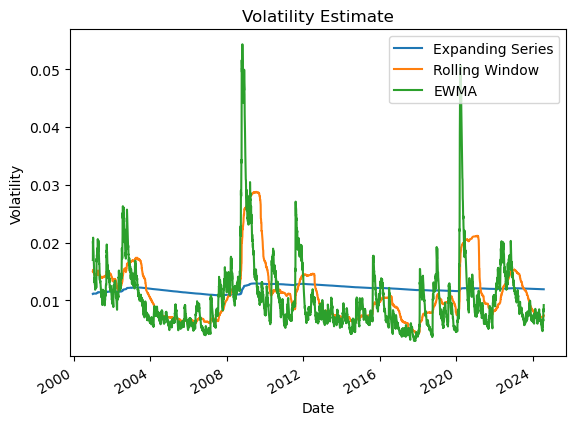

,Expanding Series,Rolling Window,EWMA
date,,,
2001-01-02,0.011099,0.015037,0.016979
2001-01-03,0.011104,0.015068,0.017063
2001-01-04,0.011160,0.015165,0.020270
2001-01-05,0.011160,0.015180,0.019835
2001-01-08,0.011184,0.015286,0.020846


In [5]:
# 1.2 Volatility
# Report
expanding_series = np.sqrt((data['Excess Returns']**2).expanding().mean().shift())

rolling_window = np.sqrt((data['Excess Returns']**2).rolling(252).mean().shift())

theta = 0.94 
ewma = np.zeros(len(data))
ewma[0] = 0.20 / np.sqrt(252)
for t in range(1, len(data)):
    ewma[t] = np.sqrt(theta * ewma[t-1]**2 + (1 - theta) * data['Excess Returns'].iloc[t-1]**2)


volatility = pd.DataFrame({
    'Expanding Series': expanding_series,
    'Rolling Window': rolling_window,
    'EWMA': ewma}, index=data.index)

volatility.loc['2001-01-02':].plot(title='Volatility Estimate', ylabel='Volatility', xlabel='Date')
plt.show()
volatility.loc['2001-01-02':].head()

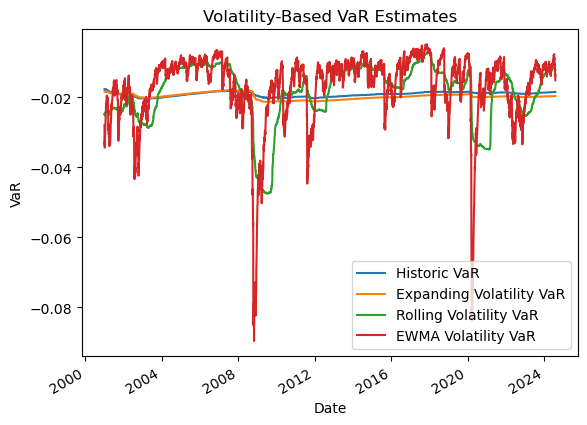

,Historic VaR,Expanding Volatility VaR,Rolling Volatility VaR,EWMA Volatility VaR
date,,,,
2024-07-29,-0.018511,-0.019655,-0.012033,-0.013951
2024-07-30,-0.018510,-0.019654,-0.012012,-0.013527
2024-07-31,-0.018510,-0.019653,-0.011983,-0.013286
2024-08-01,-0.018510,-0.019654,-0.012098,-0.014423
2024-08-02,-0.018509,-0.019654,-0.012185,-0.015141


In [6]:
z_score = -1.65
VaR['Expanding Volatility VaR'] = z_score * volatility['Expanding Series']
VaR['Rolling Volatility VaR'] = z_score * volatility['Rolling Window']
VaR['EWMA Volatility VaR'] = z_score * volatility['EWMA']
VaR.loc['2001-01-02':].plot(title='Volatility-Based VaR Estimates', ylabel='VaR', xlabel='Date')
plt.show()
VaR.tail()

In [7]:
excess_returns = data['Excess Returns']

violations_expanding = excess_returns.loc['2001-01-02':] < VaR['Expanding Volatility VaR'].loc['2001-01-02':]
violations_rolling = excess_returns.loc['2001-01-02':] < VaR['Rolling Volatility VaR'].loc['2001-01-02':]
violations_ewma = excess_returns.loc['2001-01-02':] < VaR['EWMA Volatility VaR'].loc['2001-01-02':]

freq_expanding = violations_expanding.mean()
freq_rolling = violations_rolling.mean()
freq_ewma = violations_ewma.mean()

print(f"Observed frequency of violations Volatility (Expanding): {freq_expanding:.4f}")
print(f"Observed frequency of violations Volatility (Rolling): {freq_rolling:.4f}")
print(f"Observed frequency of violations Volatility (EWMA): {freq_ewma:.4f}")
print(f"Observed frequency of violations Excess Returns (Historic): {violation_frequency:.4f}")

Observed frequency of violations Volatility (Expanding): 0.0461
Observed frequency of violations Volatility (Rolling): 0.0528
Observed frequency of violations Volatility (EWMA): 0.0599
Observed frequency of violations Excess Returns (Historic): 0.0486


1. The EWMA method has the highest violation frequency (0.0599), indicating it is the most sensitive to changes in volatility.
2. Historic VaR (0.0486) closely tracks the 5% threshold.
3. The Rolling method (0.0528) slightly exceeds 5%, showing moderate responsiveness
4. Expanding method (0.0461) falls below 5%, suggesting it is less reactive to rapid volatility shifts.

/var/folders/zq/2lldft9s0d9cwsl0tb1nf59h0000gn/T/ipykernel_12205/1784709315.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  below_var = data['Excess Returns'].iloc[:t][data['Excess Returns'].iloc[:t] < VaR['EWMA Volatility VaR'][t]]


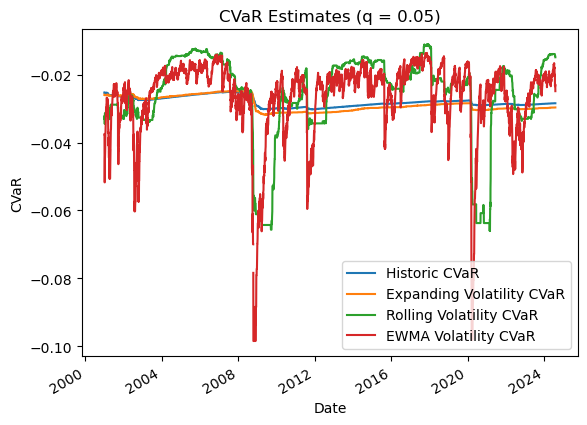

,Historic CVaR,Expanding Volatility CVaR,Rolling Volatility CVaR,EWMA Volatility CVaR
date,,,,
2001-01-02,-0.025234,-0.025849,-0.032980,-0.037553
2001-01-03,-0.025234,-0.025849,-0.032075,-0.037553
2001-01-04,-0.025234,-0.025943,-0.032075,-0.051710
2001-01-05,-0.025404,-0.026029,-0.032171,-0.051710
2001-01-08,-0.025404,-0.026029,-0.034510,-0.051710


In [8]:
CVaR = pd.DataFrame()
CVaR['Historic CVaR'] = data['Excess Returns'].expanding().apply(lambda x: x[x < x.quantile(0.05)].mean())

CVaR['Expanding Volatility CVaR'] = data['Excess Returns'].expanding().apply(lambda x: x[x < VaR['Expanding Volatility VaR'].loc[x.index[-1]]].mean())
CVaR['Rolling Volatility CVaR'] = data['Excess Returns'].rolling(252).apply(lambda x: x[x < VaR['Rolling Volatility VaR'].loc[x.index[-1]]].mean())
ewma_cvar = [np.nan]
for t in range(1, len(data)):
    below_var = data['Excess Returns'].iloc[:t][data['Excess Returns'].iloc[:t] < VaR['EWMA Volatility VaR'][t]]
    ewma_cvar.append(below_var.mean() if not below_var.empty else np.nan)
CVaR['EWMA Volatility CVaR'] = pd.Series(ewma_cvar, index=data.index)

CVaR.loc['2001-01-02':].plot(title='CVaR Estimates (q = 0.05)', ylabel='CVaR', xlabel='Date')
plt.show()
CVaR.loc['2001-01-02':].head()

In [9]:
# Violation frequencies for CVaR
violations_expanding_cvar = excess_returns.loc['2001-01-02':] < CVaR['Expanding Volatility CVaR'].loc['2001-01-02':]
violations_rolling_cvar = excess_returns.loc['2001-01-02':] < CVaR['Rolling Volatility CVaR'].loc['2001-01-02':]
violations_ewma_cvar = excess_returns.loc['2001-01-02':] < CVaR['EWMA Volatility CVaR'].loc['2001-01-02':]
violations_historic_cvar = excess_returns.loc['2001-01-02':] < CVaR['Historic CVaR'].loc['2001-01-02':]

# Calculate violation frequencies
freq_expanding_cvar = violations_expanding_cvar.mean()
freq_rolling_cvar = violations_rolling_cvar.mean()
freq_ewma_cvar = violations_ewma_cvar.mean()
freq_historic_cvar = violations_historic_cvar.mean()

# Print the results
print(f"Observed frequency of violations for Expanding Volatility CVaR: {freq_expanding_cvar:.4f}")
print(f"Observed frequency of violations for Rolling Volatility CVaR: {freq_rolling_cvar:.4f}")
print(f"Observed frequency of violations for EWMA Volatility CVaR: {freq_ewma_cvar:.4f}")
print(f"Observed frequency of violations for Historic CVaR: {freq_historic_cvar:.4f}")


Observed frequency of violations for Expanding Volatility CVaR: 0.0186
Observed frequency of violations for Rolling Volatility CVaR: 0.0248
Observed frequency of violations for EWMA Volatility CVaR: 0.0132
Observed frequency of violations for Historic CVaR: 0.0196


1. The observed frequencies of violations for CVaR are all below the 5% (0.05) threshold.
2. EWMA CVaR has the lowest violation frequency (0.0132), indicating it is highly conservative and possibly overestimates risk, reacting strongly to volatility changes.
3. Expanding Volatility CVaR (0.0186) and Historic CVaR (0.0196) are similar, suggesting both methods are more cautious but still under-predict violations.
4. Rolling Volatility CVaR (0.0248) is the least conservative but still below 5%, implying it adapts more dynamically to changing conditions but still underestimates risk.

In [10]:
# EXTRA: 1.4 GARCH
!pip install arch
from arch import arch_model

GARCH = arch_model(data['Excess Returns'], vol='Garch', p=1, o=0, q=1, dist='Normal')
GARCH_model = GARCH.fit()
GARCH_params = GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 478102237487.97205
Iteration:      2,   Func. Count:     19,   Neg. LLF: -24835.203768542287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -24835.203801495936
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [11]:
expanding_series = np.sqrt((data['Excess Returns']**2).expanding().mean().shift())
rolling_window = np.sqrt((data['Excess Returns']**2).rolling(252).mean().shift())
ewma = np.sqrt((data['Excess Returns']**2).ewm(252).mean().shift())

vol = pd.DataFrame({'expanding_series': expanding_series, 'rolling_window': rolling_window, 'ewma': ewma})

theta = 0.97
sigma1 = 0.15

avail_dates = vol.dropna().index

garch = pd.Series(0, index=avail_dates, name='GARCH')
garch[0] = sigma1

ewma[0] = sigma1

for i, ind in enumerate(avail_dates[1:], 1):
    garch[i] = np.sqrt(GARCH_params['omega'] \
        + garch[i-1]**2 * GARCH_params['beta[1]'] \
            + data['Excess Returns'].loc[ind]**2 * GARCH_params['alpha[1]'])
    ewma[i] = np.sqrt(ewma[i-1]**2 * theta + (1-theta) * data['Excess Returns'].loc[ind]**2)

vol = pd.concat([vol, garch, ewma], axis=1)
vol.dropna()

/var/folders/zq/2lldft9s0d9cwsl0tb1nf59h0000gn/T/ipykernel_12205/1150562712.py:13: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  garch[0] = sigma1
/var/folders/zq/2lldft9s0d9cwsl0tb1nf59h0000gn/T/ipykernel_12205/1150562712.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  garch[0] = sigma1
/var/folders/zq/2lldft9s0d9cwsl0tb1nf59h0000gn/T/ipykernel_12205/1150562712.py:15: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ewma[0] = sig

,expanding_series,rolling_window,ewma,GARCH,Excess Returns
date,,,,,
1995-01-06,0.006731,0.006731,0.006784,0.150000,0.006984
1995-01-09,0.006718,0.006727,0.006763,0.140723,0.007508
1995-01-10,0.006705,0.006726,0.006742,0.132021,0.007746
1995-01-11,0.006692,0.006726,0.006721,0.123858,0.007695
1995-01-12,0.006679,0.006716,0.006701,0.116201,0.007585
...,...,...,...,...,...
2024-07-29,0.011912,0.007293,0.009261,0.009873,0.009261
2024-07-30,0.011911,0.007280,0.009243,0.009560,0.009243
2024-07-31,0.011911,0.007263,0.009230,0.010441,0.009230


<Axes: title={'center': 'VaR Estimates'}, xlabel='Date', ylabel='5% VaR'>

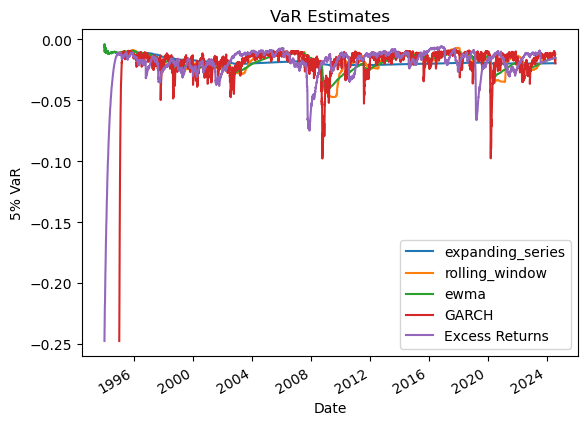

In [12]:
VaR = -1.65*vol

VaR.plot(title = 'VaR Estimates', ylabel = '5% VaR', xlabel = 'Date')

In [13]:
VaR_temp = VaR.dropna()
frequency = VaR_temp.apply(lambda x: data['Excess Returns'][VaR_temp.index] < x).mean(numeric_only=True).to_frame('frequency')
frequency.style.format('{:,.2%}')

,frequency
expanding_series,5.29%
rolling_window,5.29%
ewma,4.70%
GARCH,3.73%
Excess Returns,6.96%
